In [336]:

import numpy as np
import matplotlib.pyplot as plt
import gstools as gs
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.cluster import KMeans
import pandas as pd



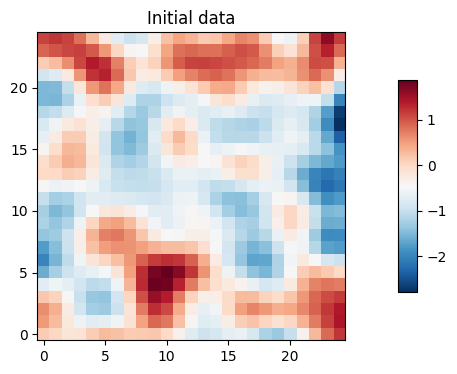

In [344]:
# dimensionxy=50
# x = np.linspace(0, 50, 50)
# y = np.linspace(0, 50, 50)
# XX, YY = np.meshgrid(x, y)


# model = gs.Gaussian(dim=2, var=1,len_scale=6)
dimensionxy=25

# 生成数据
x = np.linspace(0, 25, 25)
y = np.linspace(0, 25, 25)
XX, YY = np.meshgrid(x, y)

# 第一个数据
model = gs.Gaussian(dim=2, var=1, len_scale=3.0)
srf = gs.SRF(model,mean=0.)
srf((x, y), mesh_type='structured')
B0=srf((x, y), mesh_type='structured',seed=101)

# 可视化
fig, axes = plt.subplots(1, 1, figsize=(15, 4))

# 原始随机场
im0 = axes.imshow(B0, origin='lower', cmap='RdBu_r')
axes.set_title('Initial data')
fig.subplots_adjust(right=0.6)
cbar_ax = fig.add_axes([0.5, 0.23, 0.013, 0.53])  # [左, 下, 宽, 高]
cbar = fig.colorbar(im0, cax=cbar_ax, orientation='vertical')

plt.show()



In [338]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer

# 定义状态数
n_states = 5
est = KBinsDiscretizer(n_bins=n_states, encode='ordinal', strategy='uniform')
B_discretized = est.fit_transform(B0)

def process_single_point_NONOISY(B_discretized, row_index, col_index):
    # 构建转移概率矩阵
    transition_matrix = np.zeros((n_states, n_states))

    for month in range(24):  # 24次状态转移
        current_state = int(B_discretized[month, col_index])
        next_state = int(B_discretized[month + 1, col_index])
        transition_matrix[current_state, next_state] += 1

    # 归一化转移概率矩阵
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # 使用马尔可夫链预测指定位置的下一个状态
    last_state = int(B_discretized[row_index, col_index])
    predicted_state = np.random.choice(np.arange(n_states), p=transition_matrix[last_state])

    # 将预测的状态扩展到整个特征维度
    dummy_states = np.full((1, B_discretized.shape[1]), fill_value=-1)
    dummy_states[0, col_index] = predicted_state

    # 将预测的状态转换回实际值范围
    predicted_values = est.inverse_transform(dummy_states)
    predicted_value = predicted_values[0, col_index]

    # 添加随机扰动来模拟人为误差
    # error_margin = np.random.normal(loc=0, scale=0.05)  # 正态分布的误差，均值为0，标准差为0.05
    error_margin =  np.random.laplace(0.02,0.01)- np.random.poisson(0.02)+np.random.normal(0.02, 0.01)
    predicted_value_with_error = predicted_value +error_margin

    print(f"Predicted value for position ({row_index}, {col_index}) with error: {predicted_value_with_error}")
    return predicted_value_with_error


def process_single_point(B_discretized, row_index, col_index):
    print(B_discretized)
    # 构建转移概率矩阵
    transition_matrix = np.zeros((n_states, n_states))

    for month in range(24):  # 24次状态转移
        current_state = int(B_discretized[month, col_index])
        next_state = int(B_discretized[month + 1, col_index])
        transition_matrix[current_state, next_state] += 1

    # 归一化转移概率矩阵
    transition_matrix /= transition_matrix.sum(axis=1, keepdims=True)

    # 使用马尔可夫链预测指定位置的下一个状态
    last_state = int(B_discretized[row_index, col_index])
    predicted_state = np.random.choice(np.arange(n_states), p=transition_matrix[last_state])

    # 将预测的状态扩展到整个特征维度
    dummy_states = np.full((1, B_discretized.shape[1]), fill_value=-1)
    dummy_states[0, col_index] = predicted_state

    # 将预测的状态转换回实际值范围
    predicted_values = est.inverse_transform(dummy_states)
    predicted_value = predicted_values[0, col_index]

    # 添加随机扰动来模拟人为误差
    # error_margin = np.random.normal(loc=0, scale=0.05)  # 正态分布的误差，均值为0，标准差为0.05

    # noise=np.random.normal(0.3, 0.1) + np.random.laplace(0,0.02)
    noise=np.random.laplace(0.05,0.02)+  np.random.poisson(0.05)+np.random.normal(0.01, 0.02)

    predicted_value_with_error = predicted_value+noise

    print(f"Predicted value for position ({row_index}, {col_index}) with error: {predicted_value_with_error}")
    return predicted_value_with_error

def calcuCirculation_for_point(row_index, col_index, time):
    all_processed_values = []
    results_df = pd.DataFrame()

    if time == 2:
        for i in range(1, time):
            processed_value = process_single_point_NONOISY(B_discretized, row_index, col_index)
            all_processed_values.append(pd.Series([processed_value], name=f'Out0'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("./cluster/initial-out/pred_nonoisy_initial.csv", index=False)
    else:
        for i in range(1, time):
            processed_value = process_single_point(B_discretized, row_index, col_index)
            all_processed_values.append(pd.Series([processed_value], name=f'Out{i}'))
        results_df = pd.concat(all_processed_values, axis=1)
        results_df.to_csv("./cluster/repro-out/pred_nonoisy.csv", index=False)
        # 检查结果
        print(results_df)

# 调用函数预测特定点的下一个状态，假设你要预测第25行第10列的位置
row_index = 24  # 第25行
col_index = 9   # 第10列

times = 1001
# calcuCirculation_for_point(row_index, col_index, 2)
calcuCirculation_for_point(row_index, col_index, times)

[[4. 4. 2. 1. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 3. 3. 2. 1.
  2.]
 [4. 4. 2. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 3. 3. 4. 3. 3. 2.
  1.]
 [4. 4. 2. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 2. 3. 4. 4. 4. 4. 4. 3. 2.
  1.]
 [4. 4. 2. 0. 0. 0. 0. 0. 0. 0. 2. 3. 3. 3. 3. 4. 4. 4. 4. 4. 4. 3. 2. 2.
  1.]
 [2. 2. 1. 0. 0. 0. 0. 0. 0. 1. 2. 4. 4. 4. 4. 4. 4. 4. 3. 3. 3. 2. 2. 1.
  1.]
 [1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 3. 4. 4. 4. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1.
  1.]
 [0. 0. 1. 1. 1. 0. 0. 1. 1. 2. 3. 3. 3. 3. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1.]
 [0. 1. 2. 2. 2. 1. 1. 1. 2. 3. 3. 3. 3. 2. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.]
 [0. 1. 3. 3. 3. 2. 1. 2. 3. 3. 4. 3. 3. 2. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0.
  1.]
 [1. 2. 3. 3. 3. 2. 2. 2. 3. 4. 4. 4. 4. 3. 2. 2. 2. 2. 2. 2. 2. 2. 1. 0.
  1.]
 [2. 3. 3. 3. 3. 2. 2. 2. 3. 3. 4. 4. 4. 4. 3. 3. 3. 3. 3. 3. 3. 2. 1. 1.
  1.]
 [3. 3. 3. 4. 4. 3. 2. 2. 3. 3. 3. 4. 4. 4. 4. 4. 4. 3. 3. 3. 3. 2. 1. 0.
  0.]
 [3. 4. 4. 4. 4. 3. 2. 2. 3. 3. 4. 4. 4.

In [339]:

df = pd.read_csv("./cluster/repro-out/pred_nonoisy.csv")

df2=pd.read_csv("./cluster/initial-out/pred_nonoisy_initial.csv")

# out0 = df["Out0"]=df2["Out0"]
out0 =df2["Out0"]
# df["value0"]=df2["value0"]
x= df.index
data = df.copy()
            

Out1       0.293661
Out2       0.355684
Out3       0.321846
Out4      -0.478097
Out5       1.054584
             ...   
Out996     0.269594
Out997     1.096551
Out998    -0.433199
Out999     0.344482
Out1000    0.388806
Name: 0, Length: 1000, dtype: float64
0.403


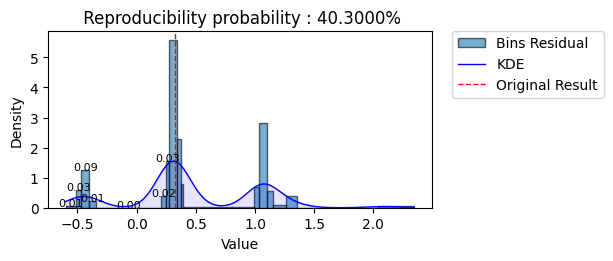

In [340]:


# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, iqr
from astropy.stats import knuth_bin_width, bayesian_blocks

# 定义不同组距计算方法
def calculate_bin_count(data, method='fd'):
    N = len(data)
    if method == 'sqrt':
        return int(np.sqrt(N))
    elif method == 'sturges':
        return int(np.log2(N) + 1)
    elif method == 'fd':
        bin_width = 2 * iqr(data) / np.cbrt(N)
        return max(1, int((data.max() - data.min()) / bin_width))
    elif method == 'scott':
        bin_width = 3.5 * np.std(data) / np.cbrt(N)
        return max(1, int((data.max() - data.min()) / bin_width))
    else:
        raise ValueError("Invalid method")

# 定义自适应组距计算方法
def calculate_adaptive_bins(data, method='knuth'):
    if method == 'knuth':
        bin_width = knuth_bin_width(data)
        bins = int((data.max() - data.min()) / bin_width)
    elif method == 'bayesian_blocks':
        bins = bayesian_blocks(data)
    else:
        raise ValueError("Invalid method")
    return bins

# 绘制直方图
def plot_histogram(ax, data, bins, color, label):
    counts, bin_edges, _ = ax.hist(data, bins=bins, density=True, alpha=0.6, edgecolor='black', color=color, label=label)
    return counts, bin_edges

# 绘制KDE曲线
def plot_kde(ax, data):
    kde = gaussian_kde(data)
    kde_x = np.linspace(data.min(), data.max(), 1000)
    kde_y = kde(kde_x)
    ax.plot(kde_x, kde_y, 'blue', linewidth=1, label='KDE')
    ax.fill_between(kde_x, kde_y, where=((kde_x >= data.min()) & (kde_x <= data.max())), color='blue', alpha=0.1)
    return kde_x, kde_y

# 标注直方图
def annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0):
    reproducibility = 0
    for j in range(len(counts)):
        if bin_edges[j] <= out0.loc[row_index].item() < bin_edges[j+1]:
            reproducibility = bin_probs[j]
            print(bin_probs[j])
            break
        ax.text(bin_edges[j] + (bin_edges[j+1] - bin_edges[j]) / 2, counts[j], f'{bin_probs[j]:.2f}', fontsize=8, ha='center')
    return reproducibility

# 绘制对比图
def plot_hist_and_kde_comparison(row_data, row_index, row_name, ax, color, out0):
    # bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
    bins = calculate_adaptive_bins(row_data, method="bayesian_blocks")
    counts, bin_edges = plot_histogram(ax, row_data, bins, color, f'Bins {row_name}')
    
    bin_widths = np.diff(bin_edges)
    bin_probs = counts * bin_widths
    plot_kde(ax, row_data)
    
    ax.axvline(out0.loc[row_index].item(), color='red', linestyle='dashed', linewidth=1, label='Original Result')
    reproducibility = annotate_histogram(ax, bin_edges, counts, bin_probs, row_index, out0)
    
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.set_title(f' Reproducibility probability : {reproducibility*100:.4f}%')
    return reproducibility

# 初始化子图
def initialize_subplots(data, plotrowcount):
    num_rows = (data.shape[0] + plotrowcount - 1) // plotrowcount
    fig, axs = plt.subplots(num_rows, plotrowcount, figsize=(plotrowcount * 5, num_rows * 3.2))
    return fig, axs, num_rows

# 隐藏多余的子图
def hide_extra_subplots(axs, data, num_rows, plotrowcount):
    for i in range(len(data), num_rows * plotrowcount):
        fig.delaxes(axs.flat[i])

# 创建图例
def create_legend(axs):
    handles, labels = [], []
    for ax in axs.flat:
        for handle, label in zip(*ax.get_legend_handles_labels()):
            if label not in labels:
                handles.append(handle)
                labels.append(label)
    return handles, labels



# rowName= ["MAE", "MAPE", "RMSE", "R2", "Adj.R2", "AIC"]
rowName= [ "Residual"]
total_probability_sum = 0
plotrowcount = 2
colors = plt.get_cmap('tab10')

from itertools import zip_longest
fig, axs, num_rows = initialize_subplots(data, plotrowcount)

for index, (row, name) in enumerate(zip(data.iterrows(), rowName)):
    print(row[1])
    # ax = axs[index // plotrowcount, index % plotrowcount]
    ax = axs[index]
    total_probability_sum += plot_hist_and_kde_comparison(row[1], index, name, ax, colors(index % 10), out0)

hide_extra_subplots(axs, data, num_rows, plotrowcount)

handles, labels = create_legend(axs)
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.45, 0.63))

plt.subplots_adjust(hspace=0.1, wspace=0.1)
average_probability = total_probability_sum / data.shape[0]
# plt.suptitle(f'The summary of reproducbility p: {average_probability*100:.4f}%', fontsize=14)
plt.tight_layout(rect=[0, 0, 0.85, 0.85])
plt.show()

In [341]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from itertools import combinations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

import warnings 

warnings.filterwarnings("ignore")

df = pd.read_csv("./cluster/repro-out/pred_nonoisy.csv")
out0 = pd.read_csv("./cluster/initial-out/pred_nonoisy_initial.csv")
data = df

# 生成所需列的列名列表
# df['Out0']=out0

column_names = [f'Out{i}' for i in range(1, 1001)]
data_df = df[column_names]
print(data_df)

       Out1      Out2      Out3      Out4      Out5      Out6      Out7  \
0  0.293661  0.355684  0.321846 -0.478097  1.054584 -0.418527  1.004307   

       Out8      Out9     Out10  ...   Out991    Out992    Out993    Out994  \
0  1.318717  1.053549  1.094601  ...  0.26624  0.341732  0.378613  0.327098   

    Out995    Out996    Out997    Out998    Out999   Out1000  
0 -0.50232  0.269594  1.096551 -0.433199  0.344482  0.388806  

[1 rows x 1000 columns]



计算 RMSE 统计量:
原始结果与复现结果之间的RMSE 95%置信区间: (0.0014, 1.0004);随机误差范围: (0.0037, 1.7239)
总误差覆盖随机-置信区间覆盖率: 1.00；概率0.8688
随机覆盖总-置信区间覆盖率: 0.58；概率0.8688

计算 ResidualError2 统计量:
原始结果与复现结果之间的ResidualError2 95%置信区间: (-1.0004, 0.7986);随机误差范围: (-1.5447, 1.5426)
总误差覆盖随机-置信区间覆盖率: 1.00；概率0.8779
随机覆盖总-置信区间覆盖率: 0.65；概率0.8779

计算 MAE 统计量:
原始结果与复现结果之间的MAE 95%置信区间: (0.0014, 1.0004);随机误差范围: (0.0039, 1.7183)
总误差覆盖随机-置信区间覆盖率: 1.00；概率0.8644
随机覆盖总-置信区间覆盖率: 0.58；概率0.8644


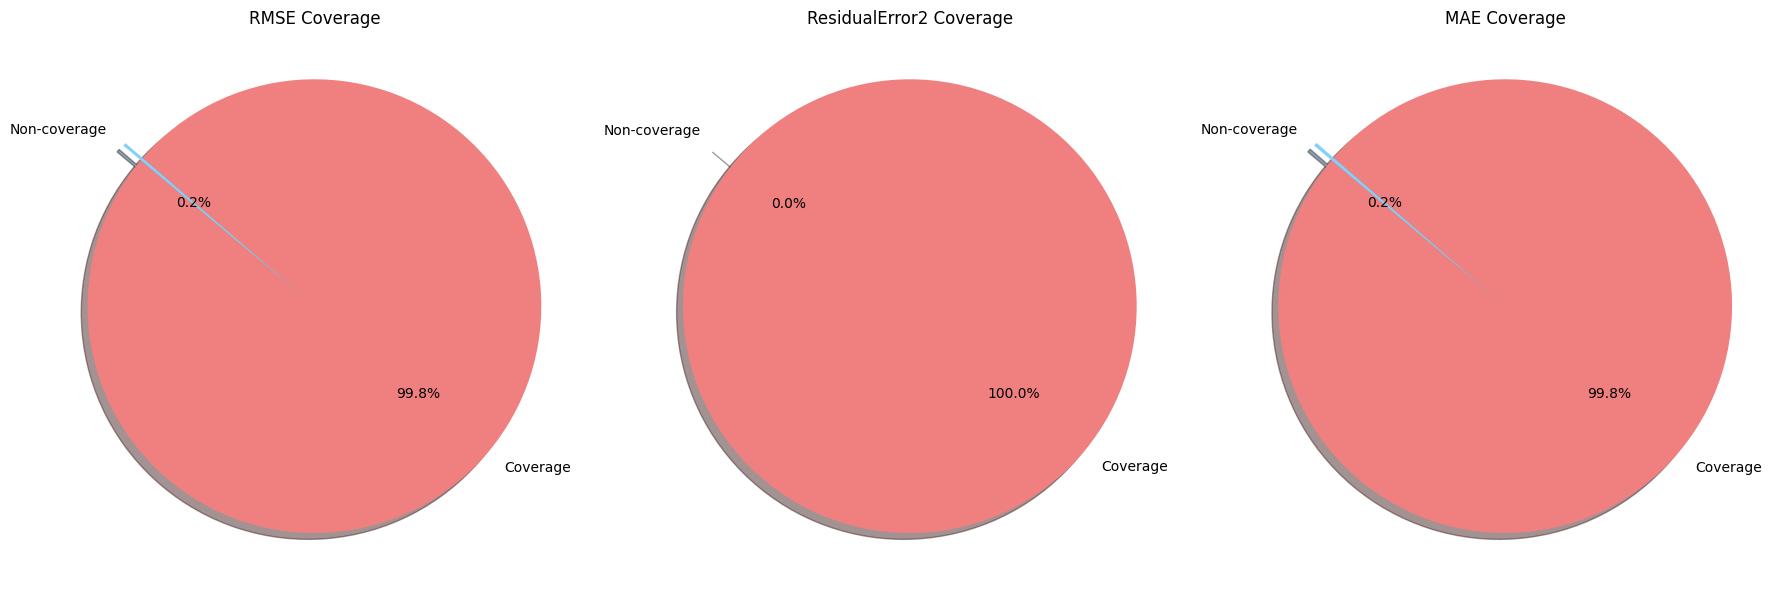

In [342]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
def calculate_coverage(interval1, interval2):
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length1
    return coverage 

def calculate_coverage2(interval1, interval2):
    # interval1 总误差
    # interval2 随机误差
    L1, U1 = interval1
    L2, U2 = interval2
    L_overlap, U_overlap = max(L1, L2), min(U1, U2)
    if L_overlap > U_overlap:
        return 0.0
    overlap_length = U_overlap - L_overlap
    length1, length2 = U1 - L1, U2 - L2
    coverage = overlap_length / length2
    return coverage 

def calculate_statistics(data):
    return np.mean(data), np.var(data), np.std(data)

def calculate_confidence_interval(values, alpha=0.05):
    
    values = np.sort(values)
    lower_bound = np.percentile(values, alpha / 2 * 100)
    upper_bound = np.percentile(values, (1 - alpha / 2) * 100)
    return lower_bound, upper_bound

def calculate_proportion(values, lower_bound, upper_bound):
    values = np.asarray(values).flatten()
    
    common_count = 0
    total_count = len(values)
    for value in values:
        if lower_bound <= value <= upper_bound:
            common_count += 1
            
    return common_count / total_count

def lins_ccc(x, y):
    mean_x, mean_y = np.mean(x), np.mean(y)
    var_x, var_y = np.var(x), np.var(y)
    cov_xy = np.mean((x - mean_x) * (y - mean_y))
    rho = cov_xy / np.sqrt(var_x * var_y)
    return (2 * rho * np.sqrt(var_x) * np.sqrt(var_y)) / (var_x + var_y + (mean_x - mean_y)**2)


def calculate_statistic_values(stat_type,outx,outy):
    if stat_type == "R2":
        return r2_score(outx, outy)
    if stat_type == "Lin's CCC":
        return lins_ccc(outx, outy)
    if stat_type=="MAE":
        return mean_absolute_error(outx, outy)
    if stat_type=="MAEP": 
        return np.mean(np.abs((outx - outy) / outx)) * 100
    if stat_type=="RMSE":
        return np.sqrt(mean_squared_error(outx, outy))
    if stat_type=="R2":
        return r2_score(outx, outy)
    if stat_type=="SSE":
        return np.sum((outx - outy) ** 2)
    if stat_type=="ResidualError":
        return np.mean((outx - outy)**2)
    if stat_type=="ResidualError2":
        return np.mean((outx - outy))



def monteCarloMethod(num_samples, data, stat_type):
    monteCarlo_values = []
    sampled_combinations = [np.random.choice(data.columns, 2, replace=False) for _ in range(num_samples)]
    for i, j in sampled_combinations:  
        monteCarlo_values.append(calculate_statistic_values(stat_type,data[i], data[j]))
    return monteCarlo_values

stat_types = ["RMSE","ResidualError2","MAE"]

# 创建一个3x1的子图布局
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for idx, stat_type in enumerate(stat_types):
    print(f"\n计算 {stat_type} 统计量:") 

    real_values = [calculate_statistic_values(stat_type, out0.values[0], data_df[f'Out{i}']) for i in range(1, 1001)]

    # 计算置信区间-----总误差
    ci_low, ci_high = calculate_confidence_interval(real_values)
    # -----随机误差
    monteCarlo_values = monteCarloMethod(10000, data_df, stat_type)


    ci_low_mc_random, ci_high_mc_random = calculate_confidence_interval(monteCarlo_values)
    print(f"原始结果与复现结果之间的{stat_type} 95%置信区间: ({ci_low:.4f}, {ci_high:.4f});随机误差范围: ({ci_low_mc_random:.4f}, {ci_high_mc_random:.4f})")
    # 计算覆盖率
    ratio_original = calculate_proportion(monteCarlo_values, ci_low, 1)
    coverage = calculate_coverage((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    coverage2 = calculate_coverage2((ci_low, 1), (ci_low_mc_random, ci_high_mc_random))
    print(f"总误差覆盖随机-置信区间覆盖率: {coverage:.2f}；概率{ratio_original}")
    print(f"随机覆盖总-置信区间覆盖率: {coverage2:.2f}；概率{ratio_original}")

    # 绘制覆盖率的饼图
    labels = ['Coverage', 'Non-coverage']
    sizes = [coverage, 1-coverage]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0.1, 0)  # 突出显示覆盖率
    axs[idx].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
                 shadow=True, startangle=140)
    axs[idx].axis('equal')
    axs[idx].set_title(f'{stat_type} Coverage')

plt.tight_layout()
plt.show()


In [343]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
## --Prediction--
# 定义计算指标的函数
def calculate_metrics(true_values, predictions, p):
    mae = mean_absolute_error(true_values, predictions)
    mape = np.mean(np.abs((true_values - predictions) / true_values)) * 100
    rmse = np.sqrt(mean_squared_error(true_values, predictions))
    r2 = r2_score(true_values, predictions)
    n = len(true_values)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    sse = np.sum((true_values - predictions) ** 2)
    aic = n * np.log(sse / n) + 2 * (p)
    residual= true_values-predictions

    return mae, mape, rmse, r2, adj_r2, aic,residual.values[0]

p = 7  # 根据你的模型的自变量数量调整
print(out0.values, data_df['Out1'])
metrics = calculate_metrics(out0.values[0], data_df['Out1'], p)


# 输出结果
print(f"MAE:{round(metrics[0],4)}")
print(f"MAPE:{round(metrics[1],4)}")
print(f"RMSE:{round(metrics[2],4)}")
print(f"R2:{round(metrics[3],4)}")
# print(f"Metrics: Adj.R2:{round(metrics[4],4)}")
# print(f"Metrics: AIC:{round(metrics[5],4)}")
print(f"Residual:{round(metrics[6],4)}")


[[0.32051007]] 0    0.293661
Name: Out1, dtype: float64
MAE:0.0268
MAPE:8.3771
RMSE:0.0268
R2:nan
Residual:0.0268
